## Data Modeling
- Model Task is binary Classification
- Data Preprocessing
- Data Augmentation
    - Undersampling
    - SMOTE
- Data Split
    - Stratified 6:2:2
    - K-fold cv
- Modeling
    - Xgboost
    - Random forest
-Evaluation
    - precision, recall
    - marco-f1-score, accuracy
    - AU - PRC

### Data Class 나누기
- Fully Paid : 1497783
- Default(Charged Off + Default) : 362981

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import os

import warnings
warnings.filterwarnings("ignore")  # 불필요한 경고 제거

ModuleNotFoundError: No module named 'xgboost'

In [4]:
data_path = "D:/archive (8)/Loan_status_2007-2020Q3.gzip"
data = pd.read_csv(data_path, low_memory=False)

In [5]:
#loan_data 특정 class만 살리고 Charged off -> Defalut class로 바꾸기기
data = data[data['loan_status'].isin(["Fully Paid", "Charged Off", "Default"])]
print(data['loan_status'].value_counts())

data['loan_status'] = data['loan_status'].replace("Charged Off", "Default")
print('\n',data['loan_status'].value_counts())

loan_status
Fully Paid     1497783
Charged Off     362548
Default            433
Name: count, dtype: int64

 loan_status
Fully Paid    1497783
Default        362981
Name: count, dtype: int64


In [6]:
# For transforming the problem into a binary classification we will encode the target so that it contains only 1, 0, and nan.

mapping = {
    "Fully Paid" : 0,
    "Default" : 1
}


def encoding_target(x):
    if isinstance(x,str):
        return mapping[x]
    return np.nan


# Performing the encoding
data['loan_status'] = data['loan_status'].map(encoding_target)
    
# Droping all irrelevant data
# data.dropna(subset=['loan_status'],inplace=True)

C:\Users\ksmin\AppData\Local\Temp\ipykernel_29492\3841752634.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


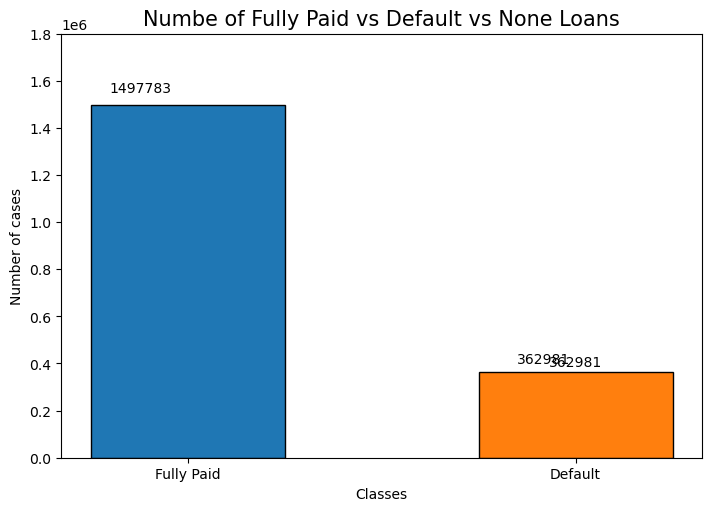

In [10]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [24]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126339946167981


### Feature preprocessing
- drop 할 것들 drop
- specific feature 변수 변환

In [12]:
#feature drop
drop_features = ['Unnamed: 0','purpose', 'title','id', 'pymnt_plan', 'policy_code','url']
data = data.drop(columns=drop_features)

In [13]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

print(len(data_x.columns))

134


In [14]:
#data 타입 변환
#퍼센트를 float형태로 바꾸기
def converting_cat_to_num(x):
    if not isinstance(x,str):
        return x  
    return float(x.split("%")[0].lstrip())

#zip code 뒤에 x 2개 빼고 float형 변환
def filter_zip_code(x):
    if not isinstance(x,str):
        return x
    return int(x[0:-2])

def to_data_tranfromer(x):
    if not isinstance(x, str):
        return np.nan
    date = x.split('-')
    if len(date) != 2:
        return np.nan  # 예상치 못한 포맷 처리
    month, year = date[0], date[1]
    return int(year + enum.get(month, "00"))  # "YYYYMM" 형식으로 변환

## 시간 데이터 확인
to_data_features = ["issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d",\
                    "last_credit_pull_d", "sec_app_earliest_cr_line", "hardship_start_date",\
                   "hardship_end_date", "payment_plan_start_date"]

enum = {'Jan':"01", 'Feb':"02", 'Mar':"03", 
        'Apr':"04", 'May':"05", 'Jun':"06",
        'Jul':"07", 'Aug':"08", 
        'Sep':"09", 'Oct':"10", 
        'Nov':"11", 'Dec':"12"}

# Converting numerically data stored as categorical
data_x['int_rate'] = data_x['int_rate'].map(converting_cat_to_num)
data_x['revol_util'] = data_x['revol_util'].map(converting_cat_to_num)

# Filtering the zip code
data_x["zip_code"] = data_x["zip_code"].map(filter_zip_code)


for name in to_data_features:
    data_x[name] = data_x[name].map(to_data_tranfromer)

print("Successfully converted!")

Successfully converted!


In [ ]:
# Analyzing the numerical data generally
number_of_missing_values = {}
percentage_of_missing_values = {}
number_of_duplicate_elements = {}
ratio_of_duplicates = {}

# Check columns
columns_name_to_check = data_x.columns
#columns_name_to_check = columns_name_to_check.drop("loan_status")
# Calculating
for name in columns_name_to_check:
    number_of_nulls = data_x[name].isnull().sum()
    number_of_missing_values[name] = number_of_nulls
    percentage_of_missing_values[name] = (number_of_nulls/len(data_x[name]))*100
    
for name in columns_name_to_check:
    number_of_duplicate_elements[name] = (data_x[name].count() - data_x[name].nunique())

for name in columns_name_to_check:
    ratio_of_duplicates[name] = number_of_duplicate_elements[name]/data_x[name].count()    

# Restructuring the Gathered Information
reassemble_data = {
                  "Attribute Names" : list(ratio_of_duplicates.keys()),
                  "Number of Missing Values" : list(number_of_missing_values.values()),
                  "Missing Values %" : list(percentage_of_missing_values.values()),
                  "Number of Duplicates" : list(number_of_duplicate_elements.values()),
                  "Ratio of Duplicates" : list(ratio_of_duplicates.values())
                  }

statistics_about_data =  pd.DataFrame(reassemble_data)

# Visualizing the Data
statistics_sorted = statistics_about_data.sort_values(by = 'Missing Values %') 
statistics_sorted.style.set_properties(subset=['Attribute Names'], **{'font-weight': 'bold'})\
.background_gradient(axis=0) #subset='Number of Duplicates')

,Attribute Names,Number of Missing Values,Missing Values %,Number of Duplicates,Ratio of Duplicates
0,loan_amnt,0,0.000000,1859196,0.999157
26,revol_bal,0,0.000000,1766468,0.949324
28,total_acc,0,0.000000,1860615,0.999920
29,initial_list_status,0,0.000000,1860762,0.999999
30,out_prncp,0,0.000000,1860331,0.999767
31,out_prncp_inv,0,0.000000,1860331,0.999767
32,total_pymnt,0,0.000000,139308,0.074866
33,total_pymnt_inv,0,0.000000,545866,0.293356
34,total_rec_prncp,0,0.000000,1593522,0.856380
25,pub_rec,0,0.000000,1860722,0.999977


In [17]:
#Missing value ratio가 5를 넘어가는 것들은 모두 drop
features_to_remove = list(statistics_sorted.loc[(statistics_sorted["Missing Values %"] > 5)]["Attribute Names"])
print(f"List of features that need to be removed: {len(features_to_remove)}")

for  name in features_to_remove:
    data_x.drop(labels=name, axis=1, inplace=True)

print("Non-high presence features have been deleted successfully!")

List of features that need to be removed: 54
Non-high presence features have been deleted successfully!


In [23]:
print(f"The number of features : {len(data_x.columns)}\nThe target feature : {data_y.columns}")

The number of features : 80
The target feature : Index(['loan_status'], dtype='object')


### Handle Missing Value
- Drop 데이터를 어차피 180만개 중에서 10만개만 사라진다.

In [27]:
print(f"Before drop: {data_x.shape[0]} samples")
data_t = pd.concat([data_x, data_y], axis = 1)
data_x_cleaned = data_t.dropna()

data_x = data_x_cleaned.drop(columns='loan_status')
data_y = data_x_cleaned[['loan_status']]

print(f"After drop: {data_x.shape[0]} samples")

Before drop: 1860764 samples
After drop: 1758019 samples


### Label Encoding

In [29]:
# 4️⃣ Label Encoding
label_encoders = {}

# 🔹 data_x: 범주형(Object) 컬럼만 Label Encoding
for col in data_x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data_x[col] = le.fit_transform(data_x[col].astype(str))  # NaN 대비 문자열 변환
    label_encoders[col] = le  # 필요하면 디코딩 가능

# 🔹 data_y: loan_status도 Label Encoding
le_y = LabelEncoder()
data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))

# 5️⃣ 변환된 데이터 확인
print("Encoded data_x sample:\n", data_x.head())
print("Encoded data_y sample:\n", data_y.head())

Encoded data_x sample:
        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
42536    12000.0      12000.0          12000.0     0     10.99       392.81   
42537     4800.0       4800.0           4800.0     0     10.99       157.13   
42538    27050.0      27050.0          27050.0     0     10.99       885.46   
42539    12000.0      12000.0          12000.0     0      7.62       373.94   
42540    14000.0      14000.0          14000.0     0     12.85       470.71   

       grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
42536      1          6               5     60000.0  ...           100.0   
42537      1          6               1     39600.0  ...           100.0   
42538      1          6               4     55000.0  ...           100.0   
42539      0          2               1     96500.0  ...           100.0   
42540      1          8               5     88000.0  ...            78.6   

       percent_bc_gt_75  pub_rec_bankruptcie

C:\Users\ksmin\AppData\Local\Temp\ipykernel_29492\3396307248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_y['loan_status'] = le_y.fit_transform(data_y['loan_status'].astype(str))


### Min - Max Scaling

In [31]:
scaler = MinMaxScaler()
data_x_scaled = scaler.fit_transform(data_x)

data_x_scaled = pd.DataFrame(data_x_scaled, columns=data_x.columns, index=data_x.index)

print("Scaled data_x sample:\n", data_x_scaled.head())

# MinMaxScaler 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler

Scaled data_x sample:
        loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
42536   0.282051     0.282051         0.287078   0.0  0.221184     0.226182   
42537   0.097436     0.097436         0.103756   0.0  0.221184     0.088752   
42538   0.667949     0.667949         0.670274   0.0  0.221184     0.513459   
42539   0.282051     0.282051         0.287078   0.0  0.089953     0.215179   
42540   0.333333     0.333333         0.338001   0.0  0.293614     0.271608   

          grade  sub_grade  home_ownership  annual_inc  ...  pct_tl_nvr_dlq  \
42536  0.166667   0.176471             1.0    0.000545  ...           1.000   
42537  0.166667   0.176471             0.2    0.000360  ...           1.000   
42538  0.166667   0.176471             0.8    0.000500  ...           1.000   
42539  0.000000   0.058824             0.2    0.000877  ...           1.000   
42540  0.166667   0.235294             1.0    0.000800  ...           0.786   

       percent_bc_gt_75  pu

### Augmentation
- Undersampling
- Oversampling_SMOTE

In [32]:
data_total = pd.concat([data_x_scaled, data_y], axis=1)
data_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1758019 entries, 42536 to 2925492
Data columns (total 81 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float64
 1   funded_amnt                 float64
 2   funded_amnt_inv             float64
 3   term                        float64
 4   int_rate                    float64
 5   installment                 float64
 6   grade                       float64
 7   sub_grade                   float64
 8   home_ownership              float64
 9   annual_inc                  float64
 10  verification_status         float64
 11  issue_d                     float64
 12  zip_code                    float64
 13  addr_state                  float64
 14  dti                         float64
 15  delinq_2yrs                 float64
 16  earliest_cr_line            float64
 17  fico_range_low              float64
 18  fico_range_high             float64
 19  inq_last_6mths        

In [43]:
# Feature와 Target 분리
X = data_total.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_total['loan_status']  # Target (타겟 변수)

# 클래스별 샘플 개수 확인
print("Original class distribution:\n", y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {X.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=X.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")


Original class distribution:
 loan_status
0    1415249
1     342770
Name: count, dtype: int64
Original data size: 1758019 samples
Undersampled data size: 685540 samples

Undersampling imbalance check
loan_status
0    342770
1    342770
Name: count, dtype: int64


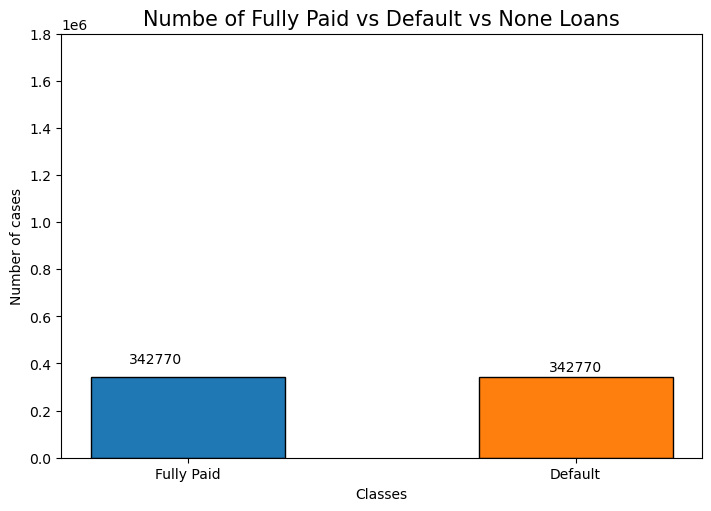

In [49]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

### Data Split
- Stratified data split 6:2:2

In [51]:
# data under 6:2:2 train,val,test set

X = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
y = data_under['loan_status']  # Target (타겟 변수)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")


Train size: 411324 samples (60.0%)
Validation size: 137108 samples (20.0%)
Test size: 137108 samples (20.0%)


### Models
- XGboost
- Random Forest

In [53]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=300, early_stopping_rounds=10):
    train_losses, val_losses = [], []
    best_val_acc = 0
    best_model = None
    no_improve = 0
    
    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}"):
        model.fit(X_train, y_train)

        # Train & Validation Accuracy
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        train_acc = accuracy_score(y_train, train_pred)
        val_acc = accuracy_score(y_val, val_pred)

        train_losses.append(1 - train_acc)  # Loss를 1 - Accuracy로 표현
        val_losses.append(1 - val_acc)

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= early_stopping_rounds:
            print(f"Early Stopping at epoch {epoch+1}")
            break

    return best_model, train_losses, val_losses, best_val_acc

def plot_loss_curve(train_losses, val_losses, model_name):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (1 - Accuracy)')
    plt.title(f"{model_name} Training Loss Curve")
    plt.legend()
    plt.show()

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # Precision, Recall, F1-score
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # AU-PRC 계산
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    auc_prc = auc(recall, precision)

    # AU-PRC 곡선 그리기
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.show()
    
    return accuracy_score(y_test, y_pred)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=500,  
        max_depth=15,      
        min_samples_split=4,  
        min_samples_leaf=2,   
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=500,       
        learning_rate=0.1,      
        max_depth=6,          
        subsample=0.9,         
        colsample_bytree=0.9,  
        random_state=42
    )
}

In [ ]:
best_val_accs = {}
best_test_accs = {}

for model_name, model in models.items():
    print(f"\n🚀 Training {model_name}...")
    
    # 모델 학습 (Early Stopping 적용)
    best_model, train_losses, val_losses, best_val_acc = train_model(model, X_train, y_train, X_val, y_val, epochs=300, early_stopping_rounds=10)
    
    # 학습 곡선 시각화
    plot_loss_curve(train_losses, val_losses, model_name)
    
    # 모델 평가 (Precision, Recall, F1-score, AU-PRC)
    test_acc = evaluate_model(best_model, X_test, y_test, model_name)
    
    # 성능 저장
    best_val_accs[model_name] = best_val_acc
    best_test_accs[model_name] = test_acc

print("\n🎯 Best Model Performance Summary:")
for model_name in models.keys():
    print(f"{model_name} - Best Val Accuracy: {best_val_accs[model_name]:.4f}, Test Accuracy: {best_test_accs[model_name]:.4f}")